In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from dateutil.relativedelta import relativedelta

# Import your classes
from classes.instruments import Stock, AmericanOption
from classes.position import Position
from classes.portfolio import Portfolio
from classes.pricer import Pricer, AmericanPricer

In [2]:
# Data loading
# ===========
print("Loading market data...")
try:
    df = pd.read_csv("data/data.csv", sep=";").replace("#N/A N/A", np.nan)
    df = df.iloc[1:].reset_index(drop=True)
    df = df.set_index(df['Dates'])
    df.drop(columns='Dates', inplace=True)
    df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
    df = df.loc[df.index > pd.to_datetime("2018-01-01")]
    
    symbol_col = [" ".join(c.split(" ")[:3]) for c in df.columns if "Equity" in c]
    corrected_columns = []
    for c in range(len(df.columns)):
        if c <= 2:
            corrected_columns.append(df.columns[c])
        else:
            if c % 2 == 1:
                corrected_columns.append(df.columns[c] + " Price")
            else:
                corrected_columns.append(" ".join(corrected_columns[-1].split(" ")[:3]) + " Vol")
    df.columns = corrected_columns
    df = df.astype(float)
    
    print("Available columns:", df.columns.tolist())
    
    stock_columns = [col for col in df.columns if "Equity Price" in col]
    if not stock_columns:
        raise ValueError("No stock price columns found")
        
    stock_ticker = stock_columns[0].split(" Equity")[0].strip()
    price_col = f"{stock_ticker} Equity Price"
    vol_col = f"{stock_ticker} Equity Vol"
    
    print(f"Selected stock: {stock_ticker}")
    print(f"Price column: {price_col}")
    print(f"Volatility column: {vol_col}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Using sample data for testing")
    
    dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='B')
    df = pd.DataFrame(index=dates)
    
    # Sample columns
    stock_ticker = "SAMPLE"
    price_col = f"{stock_ticker} Equity Price"
    vol_col = f"{stock_ticker} Equity Vol"
    
    df["USGG2YR Index"] = 0.05  # 5% interest rate
    
    initial_price = 100
    price_changes = np.random.normal(0, 1, len(dates))
    prices = initial_price * np.exp(np.cumsum(price_changes) * 0.01)
    df[price_col] = prices
    
    df[vol_col] = 20 + np.sin(np.linspace(0, 8*np.pi, len(dates))) * 5  # 15-25% volatility with cyclical pattern


Loading market data...
Available columns: ['USGG2YR Index', 'ES1 Index', 'SX5E Index', 'DG FP Equity Price', 'DG FP Equity Vol', 'TTE FP Equity Price', 'TTE FP Equity Vol', 'AI FP Equity Price', 'AI FP Equity Vol', 'EL FP Equity Price', 'EL FP Equity Vol', 'AIR FP Equity Price', 'AIR FP Equity Vol', 'CS FP Equity Price', 'CS FP Equity Vol', 'CAP FP Equity Price', 'CAP FP Equity Vol', 'SGO FP Equity Price', 'SGO FP Equity Vol', 'HENKEL HB Equity Price', 'HENKEL HB Equity Vol', 'ML FP Equity Price', 'ML FP Equity Vol', 'MC FP Equity Price', 'MC FP Equity Vol', 'ORA FP Equity Price', 'ORA FP Equity Vol', 'SU FP Equity Price', 'SU FP Equity Vol', 'SAN FP Equity Price', 'SAN FP Equity Vol', 'PUB FP Equity Price', 'PUB FP Equity Vol', 'TE FP Equity Price', 'TE FP Equity Vol', 'NESN SW Equity Price', 'NESN SW Equity Vol', 'GE US Equity Price', 'GE US Equity Vol', 'AAPL US Equity Price', 'AAPL US Equity Vol']
Selected stock: DG FP
Price column: DG FP Equity Price
Volatility column: DG FP Equit

Running strategy comparison from 2018-01-02 00:00:00 to 2025-02-21 00:00:00

Running Straddle (ATM)...
  Net premium collected: $3.34
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1 Call(s) @ 68
  Short 1 Put(s) @ 68
  Net premium collected: $4.18
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1 Call(s) @ 69
  Short 1 Put(s) @ 69
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 68 / Price at T: 66.8369 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: Settlement = -1.16
Option K: 68 / Price at T: 66.8369 / PnL: 1.1631
  Net premium collected: $4.02
Entered strategy on 2018-03-01 00:00:00, expiry: 2018-04-20 00:00:00
  Short 1 Call(s) @ 64
  Short 1 Put(s) @ 64
Settled option Call position on 2018-03-16 00:00:00: Settlement = 0.00
Option K: 69 / Price at T: 66.0801 / PnL: 0
Settled option Put position on 2018-03-16 00:00:00: Settlement = -2.92
Option K: 69 / Price at T: 66.0801 / PnL:

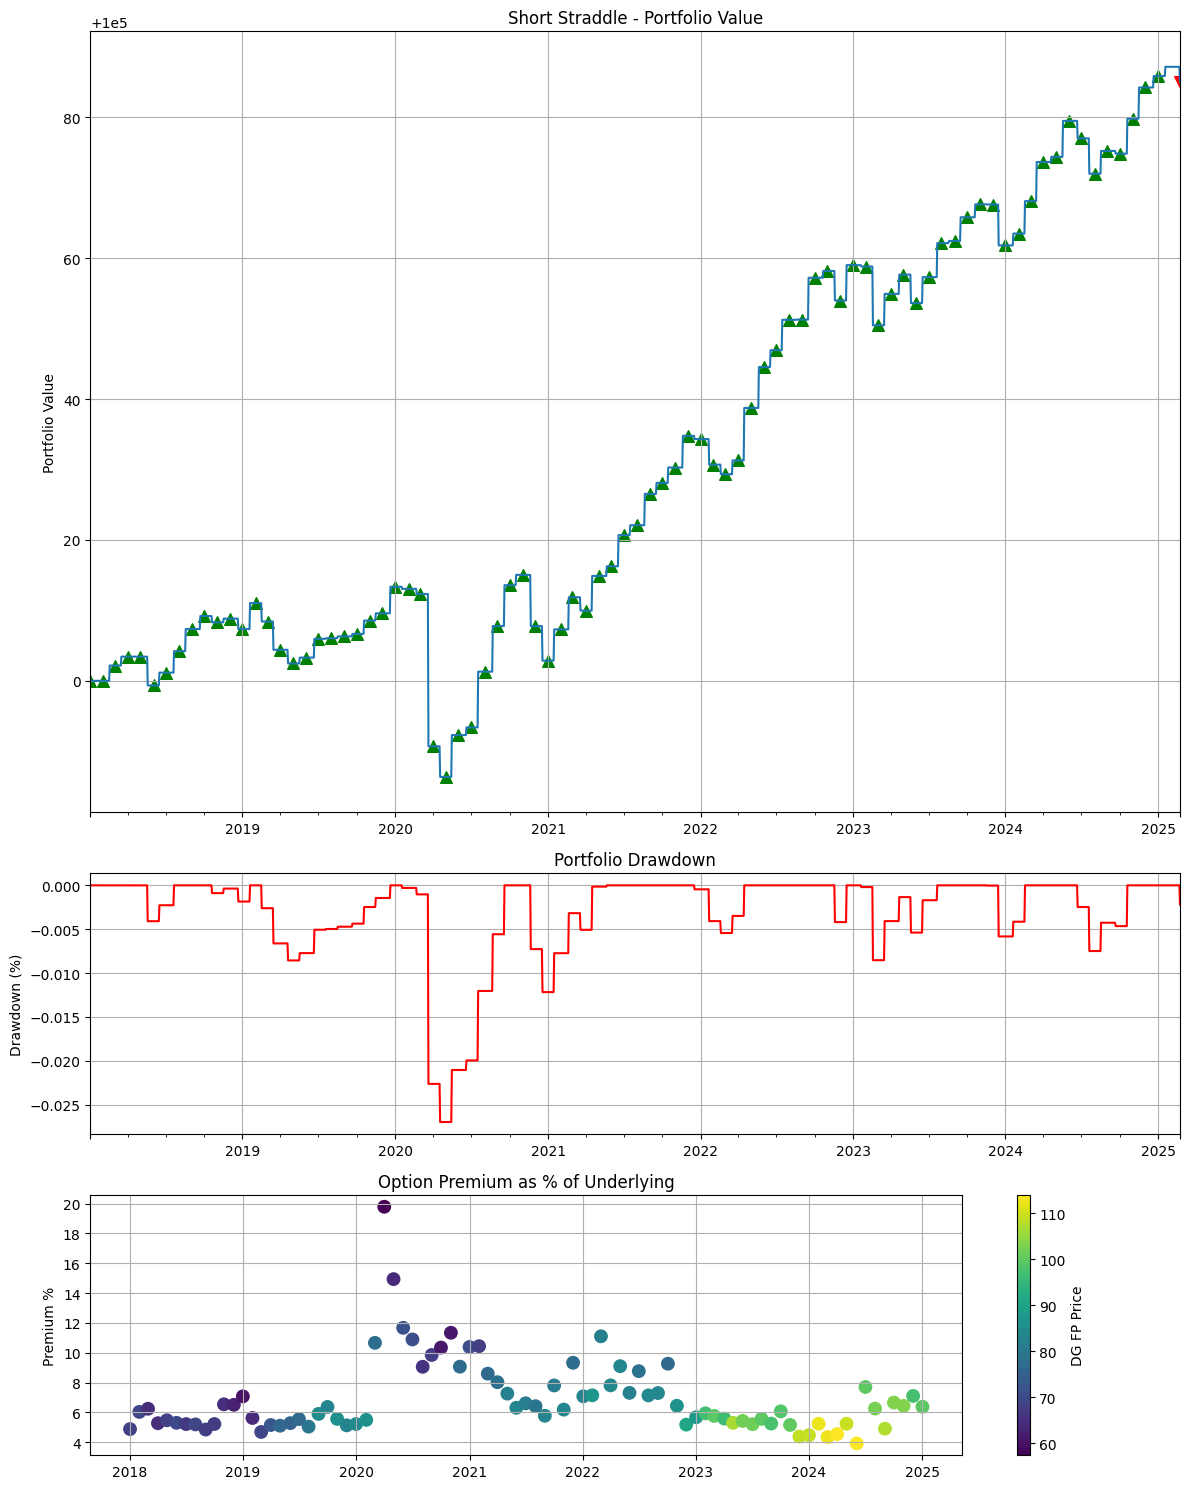


Running Strangle (5% OTM)...
  Net premium collected: $0.93
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1 Call(s) @ 72
  Short 1 Put(s) @ 65
  Net premium collected: $1.58
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1 Call(s) @ 73
  Short 1 Put(s) @ 66
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 72 / Price at T: 66.8369 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 65 / Price at T: 66.8369 / PnL: 0
  Net premium collected: $1.45
Entered strategy on 2018-03-01 00:00:00, expiry: 2018-04-20 00:00:00
  Short 1 Call(s) @ 68
  Short 1 Put(s) @ 61
Settled option Call position on 2018-03-16 00:00:00: Settlement = 0.00
Option K: 73 / Price at T: 66.0801 / PnL: 0
Settled option Put position on 2018-03-16 00:00:00: Settlement = 0.00
Option K: 66 / Price at T: 66.0801 / PnL: 0
  Net premium collected: $0.97
Entered strategy on 2018-04-02 00:00:00, expir

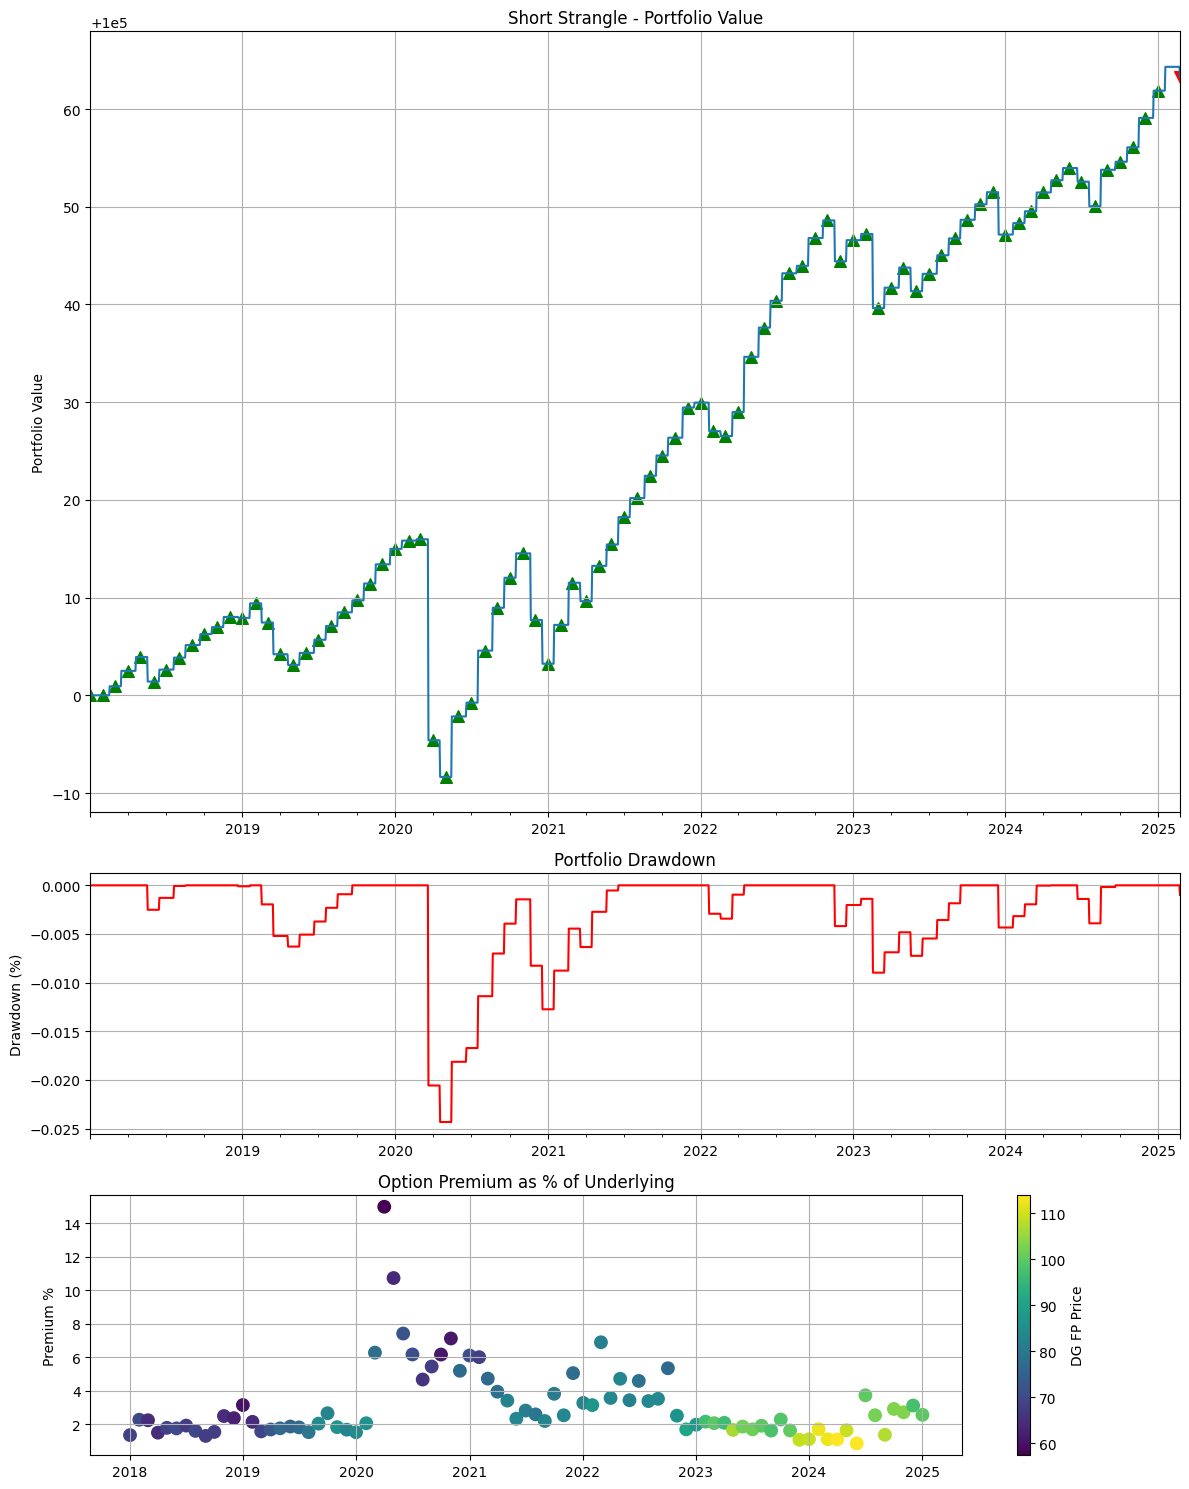


Running Iron Condor...
  Net premium collected: $0.72
Entered strategy on 2018-01-02 00:00:00, expiry: 2018-02-16 00:00:00
  Short 1 Call(s) @ 72
  Short 1 Put(s) @ 65
  Long 1 Call(s) @ 75
  Long 1 Put(s) @ 62
  Net premium collected: $1.13
Entered strategy on 2018-02-01 00:00:00, expiry: 2018-03-16 00:00:00
  Short 1 Call(s) @ 73
  Short 1 Put(s) @ 66
  Long 1 Call(s) @ 76
  Long 1 Put(s) @ 62
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 72 / Price at T: 66.8369 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 65 / Price at T: 66.8369 / PnL: 0
Settled option Call position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 75 / Price at T: 66.8369 / PnL: 0
Settled option Put position on 2018-02-16 00:00:00: Settlement = 0.00
Option K: 62 / Price at T: 66.8369 / PnL: 0
  Net premium collected: $0.98
Entered strategy on 2018-03-01 00:00:00, expiry: 2018-04-20 00:00:00
  Short 1 Call(s) @ 68
  Short 1 Put(s) @ 

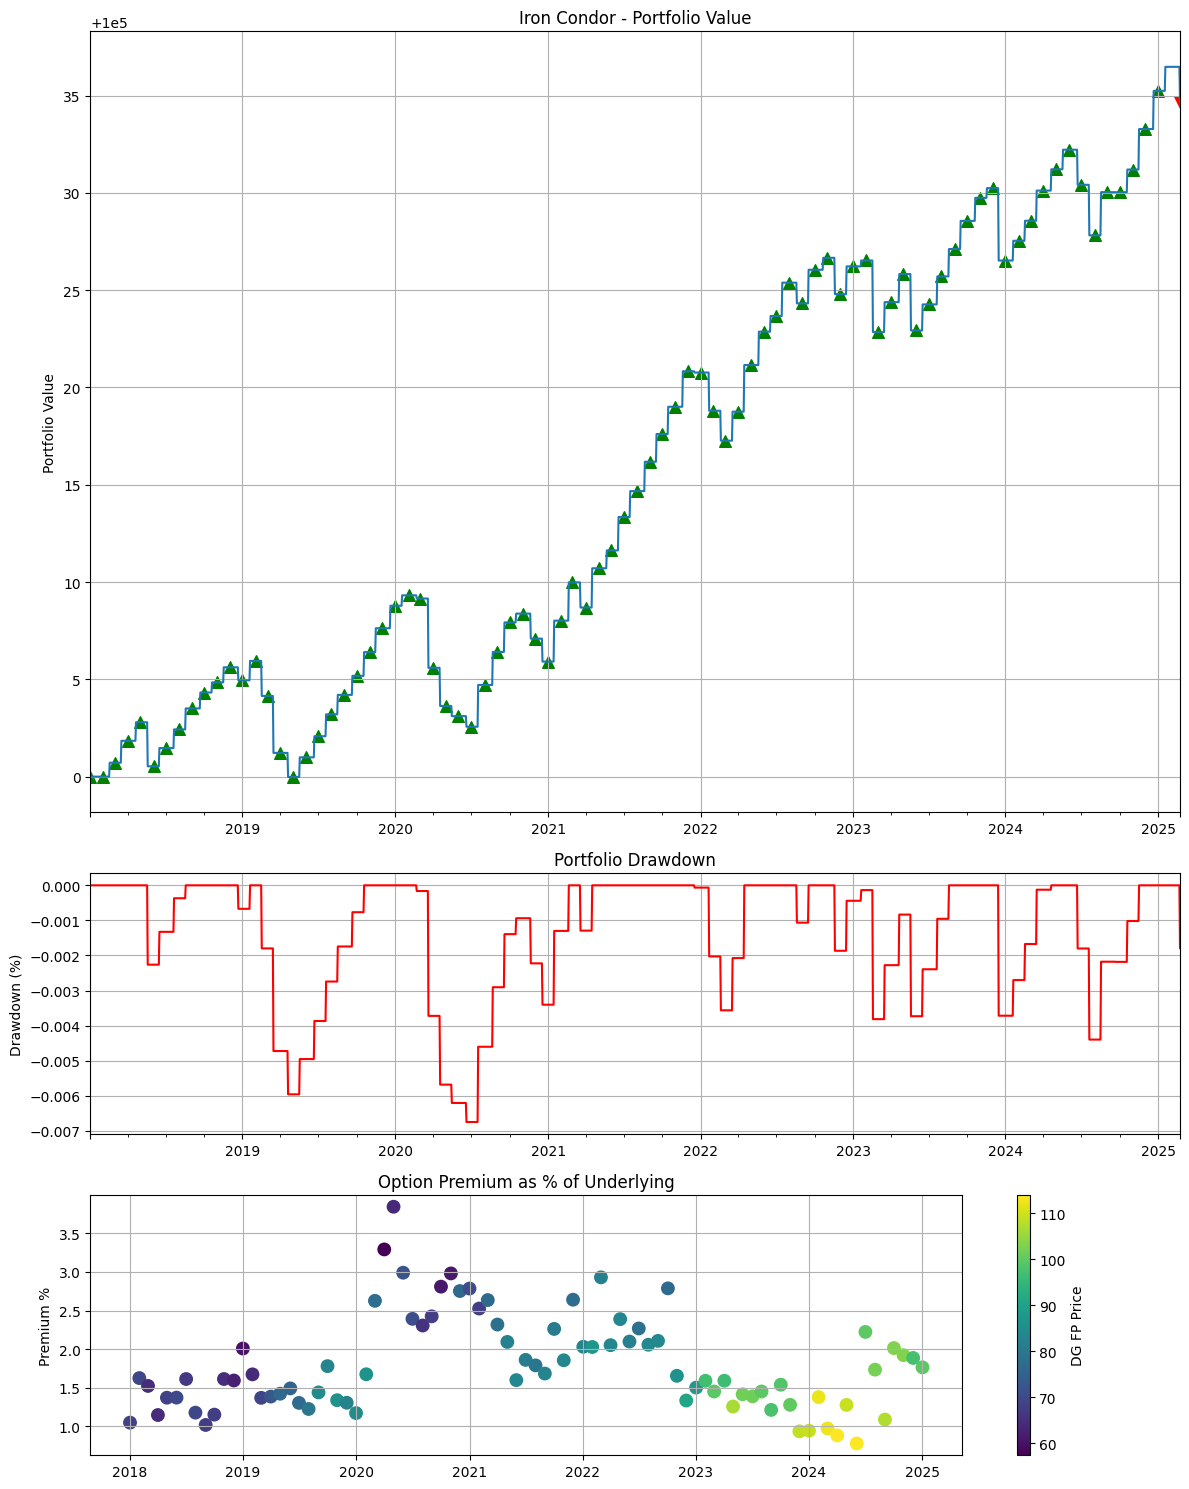

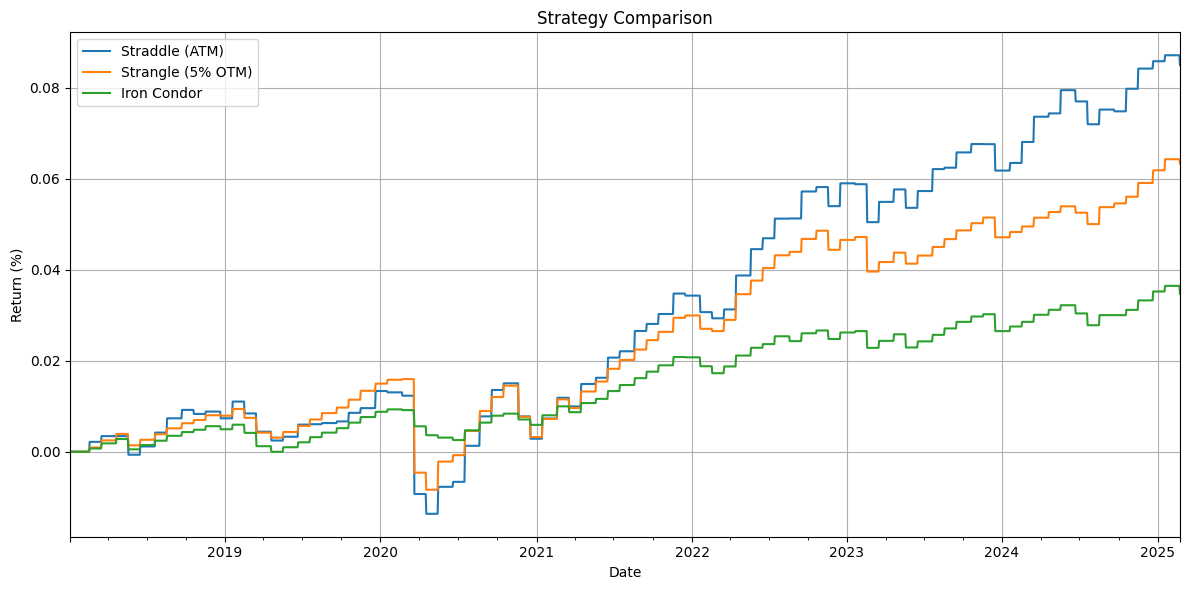

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Import your classes
from classes.instruments import Stock, AmericanOption
from classes.position import Position
from classes.portfolio import Portfolio
from classes.pricer import Pricer, AmericanPricer

def get_third_friday(year, month):
    """Get the third Friday of a given month and year"""
    date = datetime(year, month, 1)
    days_until_friday = (4 - date.weekday()) % 7
    first_friday = date + timedelta(days=days_until_friday)
    third_friday = first_friday + timedelta(days=14)
    return pd.Timestamp(third_friday)

class OptionStrategy:
    """Base class to run option strategies"""
    
    def __init__(self, df, stock_ticker, start_date, end_date, initial_capital=100000.0):
        self.df = df
        self.stock_ticker = stock_ticker
        self.start_date = pd.Timestamp(start_date)
        self.end_date = pd.Timestamp(end_date)
        self.initial_capital = initial_capital
        self.portfolio = Portfolio(name="Option Strategy")
        self.portfolio.adjust_bank(initial_capital, start_date)
        self.pricer = AmericanPricer(steps=100)
        
        # Track results
        self.trades = []
        self.daily_values = {self.start_date: initial_capital}
        self.trade_months = set()
    
    def run_monthly_strategy(self, strategy_func):
        """
        Run a monthly option strategy
        
        Parameters:
        -----------
        strategy_func : callable
            Function that creates and returns option positions for a given date
        """
        # Get dates for backtest
        dates = sorted(self.df.index[(self.df.index >= self.start_date) & 
                                    (self.df.index <= self.end_date)])
        
        # Track current trade
        current_trade = None
        last_trade_date = None
        
        # Initialize to track premium collection
        total_premium_collected = 0.0
        
        for date in dates:
            try:
                # Get current market data
                price = float(self.df.loc[date, f"{self.stock_ticker} Equity Price"])
                iv = float(self.df.loc[date, f"{self.stock_ticker} Equity Vol"]) / 100
                rate = float(self.df.loc[date, "USGG2YR Index"]) / 100
                
                # Copy positions from previous date if needed
                previous_dates = [d for d in self.portfolio.positions_dict.keys() if d < date]
                if previous_dates and date not in self.portfolio.positions_dict:
                    latest_previous = max(previous_dates)
                    self.portfolio.positions_dict[date] = self.portfolio.positions_dict[latest_previous].copy()
                    
                    # Copy bank balance too
                    if date not in self.portfolio.bank_dict and latest_previous in self.portfolio.bank_dict:
                        self.portfolio.bank_dict[date] = self.portfolio.bank_dict[latest_previous]
                
                # Update positions with current market data
                if date in self.portfolio.positions_dict:
                    for pos in self.portfolio.positions_dict[date]:
                        if hasattr(pos.instrument, 'underlying'):
                            pos.instrument.underlying._price = price
                            
                        # Update option parameters
                        if hasattr(pos.instrument, 'sigma'):
                            pos.instrument.sigma = iv
                            pos.instrument.r = rate
                            if hasattr(pos.instrument, 'expiry_date') and pos.instrument.expiry_date:
                                pos.instrument.T = max((pos.instrument.expiry_date - date).days / 365, 0.001)
                
                # Check if it's time for a new monthly trade
                current_month_year = (date.year, date.month)
                if current_month_year not in self.trade_months:
                    # Calculate expiration (next month's third Friday)
                    next_month = date.month + 1 if date.month < 12 else 1
                    next_year = date.year if date.month < 12 else date.year + 1
                    expiry_date = get_third_friday(next_year, next_month)
                    
                    # Only proceed if expiry is within our test period
                    if expiry_date <= self.end_date:
                        # Create stock
                        stock = Stock(price=price, ticker=self.stock_ticker)
                        
                        # Call the strategy function to get option positions
                        options = strategy_func(date, expiry_date, stock, price, iv, rate)
                        
                        # Create trade record
                        current_trade = {
                            'entry_date': date,
                            'expiry_date': expiry_date,
                            'entry_price': price,
                            'options': options,
                            'status': 'open',
                            'daily_values': {}
                        }
                        
                        # Add options to portfolio and track premium
                        trade_premium = 0.0
                        for option, action, quantity in options:
                            option.update_price(self.pricer)
                            
                            # Calculate premium impact
                            # For shorts we receive premium, for longs we pay premium
                            premium_impact = option.price * quantity
                            if action == "Short":
                                trade_premium += premium_impact
                            else:
                                trade_premium -= premium_impact
                            
                            self.portfolio.add_position(Position(
                                instrument=option,
                                quantity=quantity,
                                date=date,
                                action=action
                            ))
                        
                        # Track total premium collected
                        total_premium_collected += trade_premium
                        current_trade['net_premium'] = trade_premium
                        
                        # Track the trade
                        self.trades.append(current_trade)
                        self.trade_months.add(current_month_year)
                        last_trade_date = date
                        
                        print(f"  Net premium collected: ${trade_premium:.2f}")
                        
                        # Log trade
                        print(f"Entered strategy on {date}, expiry: {expiry_date}")
                        for option, action, quantity in options:
                            print(f"  {action} {quantity} {option.option_type}(s) @ {option.K}")
                
                # Check for expired options
                self.portfolio.check_option_expired(date, price, self.stock_ticker)
                
                # Update portfolio values
                self.portfolio.update_all(date, self.pricer)
                
                # Get current portfolio value - adjust to show initial capital + premium collection
                # This adjusts for the issue in the Portfolio.get_portfolio_value() method
                raw_portfolio_value = self.portfolio.get_portfolio_value()
                
                # For display, show theoretical P&L (initial capital + net change)
                # This approach preserves the true P&L pattern rather than the misleading downward slope
                bank_value = self.portfolio.get_bank_value() if date in self.portfolio.bank_dict else 0
                position_values = 0
                
                if date in self.portfolio.positions_dict:
                    for pos in self.portfolio.positions_dict[date]:
                        if not pos.closed:
                            # For short positions, profit from decreasing price
                            sign = -1 if pos.action == "Short" else 1
                            if hasattr(pos.instrument, 'price'):
                                position_values += sign * pos.quantity * pos.instrument.price
                
                # Store the corrected portfolio value
                self.daily_values[date] = self.initial_capital + bank_value + position_values
                
                # Track option values for current trade
                if current_trade and current_trade['status'] == 'open':
                    # Check if this trade has expired
                    if date >= current_trade['expiry_date']:
                        current_trade['status'] = 'closed'
                        current_trade['exit_date'] = date
                        current_trade['exit_price'] = price
                        
                        print(f"Closed position on {date}, price: {price}")
                
            except Exception as e:
                print(f"Error on {date}: {e}")
                # Carry forward previous value if available
                if self.daily_values and date > min(self.daily_values.keys()):
                    last_date = max(d for d in self.daily_values.keys() if d < date)
                    self.daily_values[date] = self.daily_values[last_date]
        
        return pd.Series(self.daily_values)
    
    def plot_results(self):
        """Plot strategy results"""
        values_series = pd.Series(self.daily_values)
        
        # Create plot with subplots
        fig, axs = plt.subplots(3, 1, figsize=(12, 15), gridspec_kw={'height_ratios': [3, 1, 1]})
        
        # Portfolio value
        values_series.plot(ax=axs[0])
        axs[0].set_title(f"{self.portfolio.name} - Portfolio Value")
        axs[0].set_ylabel("Portfolio Value")
        axs[0].grid(True)
        
        # Mark trade entry and exit points
        for trade in self.trades:
            if trade['entry_date'] in values_series.index:
                axs[0].scatter(trade['entry_date'], values_series[trade['entry_date']], 
                             color='green', marker='^', s=70)
            
            if 'exit_date' in trade and trade['exit_date'] in values_series.index:
                axs[0].scatter(trade['exit_date'], values_series[trade['exit_date']], 
                             color='red', marker='v', s=70)
        
        # Drawdown
        drawdown = (values_series / values_series.cummax() - 1) * 100
        drawdown.plot(ax=axs[1], color='red')
        axs[1].set_title("Portfolio Drawdown")
        axs[1].set_ylabel("Drawdown (%)")
        axs[1].grid(True)
        
        # Option Premium Chart
        entry_dates = [t['entry_date'] for t in self.trades]
        entry_prices = [t['entry_price'] for t in self.trades]
        
        if entry_dates:
            # Calculate option premiums
            premiums = []
            for trade in self.trades:
                total_premium = 0
                for option, action, quantity in trade['options']:
                    sign = -1 if action.lower() == 'short' else 1
                    total_premium += sign * option.price * quantity
                premiums.append(abs(total_premium))
            
            # Calculate as percentage of underlying
            premium_pcts = [premium / price * 100 for premium, price in zip(premiums, entry_prices)]
            
            sc = axs[2].scatter(entry_dates, premium_pcts, c=entry_prices, cmap='viridis', s=80)
            axs[2].set_title("Option Premium as % of Underlying")
            axs[2].set_ylabel("Premium %")
            axs[2].grid(True)
            
            # Add colorbar
            cbar = plt.colorbar(sc, ax=axs[2])
            cbar.set_label(f"{self.stock_ticker} Price")
        
        plt.tight_layout()
        plt.show()

def run_straddle(df, stock_ticker, start_date, end_date, atm=True, initial_capital=100000.0):
    """
    Run a short straddle strategy
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    atm : bool
        Whether to use at-the-money strikes or slightly OTM
    initial_capital : float
        Initial capital for the strategy
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Short Straddle"
    
    def straddle_strategy(date, expiry, stock, price, iv, rate):
        # Define strikes
        if atm:
            # ATM strikes
            call_strike = put_strike = round(price)
        else:
            # Slightly OTM strikes
            call_strike = round(price * 1.05)
            put_strike = round(price * 0.95)
        
        # Calculate time to expiration
        T = (expiry - date).days / 365
        
        # Create the options
        call_option = AmericanOption(
            underlying=stock,
            K=call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        put_option = AmericanOption(
            underlying=stock,
            K=put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        # Return as a list of (option, action, quantity) tuples
        return [(call_option, "Short", 1), (put_option, "Short", 1)]
    
    # Run the strategy
    values = strategy.run_monthly_strategy(straddle_strategy)
    
    # Plot results
    strategy.plot_results()
    
    return strategy, values

def run_strangle(df, stock_ticker, start_date, end_date, otm_pct=0.05, initial_capital=100000.0):
    """
    Run a short strangle strategy
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    otm_pct : float
        Percentage OTM for strike selection
    initial_capital : float
        Initial capital for the strategy
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Short Strangle"
    
    def strangle_strategy(date, expiry, stock, price, iv, rate):
        # Define strikes
        call_strike = round(price * (1 + otm_pct))
        put_strike = round(price * (1 - otm_pct))
        
        # Calculate time to expiration
        T = (expiry - date).days / 365
        
        # Create the options
        call_option = AmericanOption(
            underlying=stock,
            K=call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        put_option = AmericanOption(
            underlying=stock,
            K=put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        # Return as a list of (option, action, quantity) tuples
        return [(call_option, "Short", 1), (put_option, "Short", 1)]
    
    # Run the strategy
    values = strategy.run_monthly_strategy(strangle_strategy)
    
    # Plot results
    strategy.plot_results()
    
    return strategy, values

def run_strangle_with_wings(df, stock_ticker, start_date, end_date, otm_pct=0.05, wing_pct=0.10, initial_capital=100000.0):
    """
    Run a short strangle with protective wings (iron condor)
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    otm_pct : float
        Percentage OTM for short strikes
    wing_pct : float
        Percentage OTM for long protective wings
    initial_capital : float
        Initial capital for the strategy
    """
    strategy = OptionStrategy(df, stock_ticker, start_date, end_date, initial_capital)
    strategy.portfolio.name = "Iron Condor"
    
    def iron_condor_strategy(date, expiry, stock, price, iv, rate):
        short_call_strike = round(price * (1 + otm_pct))
        short_put_strike = round(price * (1 - otm_pct))
        long_call_strike = round(price * (1 + wing_pct))
        long_put_strike = round(price * (1 - wing_pct))
        
        T = (expiry - date).days / 365
        
        short_call = AmericanOption(
            underlying=stock,
            K=short_call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        short_put = AmericanOption(
            underlying=stock,
            K=short_put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        long_call = AmericanOption(
            underlying=stock,
            K=long_call_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Call",
            expiry_date=expiry
        )
        
        long_put = AmericanOption(
            underlying=stock,
            K=long_put_strike,
            T=T,
            r=rate,
            sigma=iv,
            option_type="Put",
            expiry_date=expiry
        )
        
        return [
            (short_call, "Short", 1),
            (short_put, "Short", 1),
            (long_call, "Long", 1),
            (long_put, "Long", 1)
        ]
    
    values = strategy.run_monthly_strategy(iron_condor_strategy)
    
    strategy.plot_results()
    
    return strategy, values

def compare_strategies(df, stock_ticker, start_date, end_date, initial_capital=100000.0):
    """
    Compare multiple option strategies
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with price and volatility data
    stock_ticker : str
        Stock ticker symbol
    start_date : pandas.Timestamp
        Start date for backtest
    end_date : pandas.Timestamp
        End date for backtest
    initial_capital : float
        Initial capital for each strategy
    """
    # Define strategies to run
    strategies = [
        ('Straddle (ATM)', lambda: run_straddle(df, stock_ticker, start_date, end_date, atm=True, initial_capital=initial_capital)),
        ('Strangle (5% OTM)', lambda: run_strangle(df, stock_ticker, start_date, end_date, otm_pct=0.05, initial_capital=initial_capital)),
        ('Iron Condor', lambda: run_strangle_with_wings(df, stock_ticker, start_date, end_date, otm_pct=0.05, wing_pct=0.10, initial_capital=initial_capital))
    ]
    
    # Run each strategy
    results = {}
    for name, run_func in strategies:
        print(f"\nRunning {name}...")
        try:
            strategy, values = run_func()
            results[name] = values
        except Exception as e:
            print(f"Error running {name}: {e}")
            import traceback
            traceback.print_exc()
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    
    for name, values in results.items():
        # Calculate percentage return
        pct_return = (values / values.iloc[0] - 1) * 100
        pct_return.plot(label=name)
    
    plt.title('Strategy Comparison')
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return results

def main():
    """Run example strategies"""
    try:
        stock_ticker = "DG FP"  # Based on your data
        
        end_date = df.index.max()
        start_date = pd.Timestamp("2015-01-01")
        
        start_date = max(start_date, df.index.min())
        
        print(f"Running strategy comparison from {start_date} to {end_date}")
        
        results = compare_strategies(df, stock_ticker, start_date, end_date)
        
        return results
        
    except Exception as e:
        print(f"Error in main: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    results = main()